# SSDの推論の実施
pytorchのversion<=1.4が望ましい

## 目標
1. 学習して保存したSSDモデルを使用してSSDの推論を実装できるようになる (画像中の物体検出を行う)

## モデルを組み立てて学習済みパラメータをロードする
cpuで推論するみたい

## Library

In [6]:
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
from utils.ssd_model import SSD

# SSD300の設定
ssd_cfg = {
    'num_classes' : 21,                                                                   #　背景クラスを含めた合計クラス数
    'input_size' : 300,                                                                     # 画像の入力サイズ
    'bbox_aspect_num' : [4, 6, 6, 6, 4, 4],                                  # 出力するDBoxのアスペクト比の種類
    'feature_maps' : [38, 19, 10, 5, 3, 1],                                   # 各source（feature map）の画像サイズ　
    'steps' : [8, 16, 32, 64, 100, 300],                                        # DBOXの大きさを決める
    'min_sizes' : [30, 60, 111, 162, 213, 264],                         # 
    'max_sizes' : [60, 111, 162, 213, 264, 315],
    'aspect_ratios' : [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

# ネットワークモデル
net = SSD(phase='inference', cfg=ssd_cfg)

# SSDの重みの初期値を設定
net_weights = torch.load('./weights/ssd300_50.pth')
net.load_state_dict(net_weights)

# GPUが使えるかを確認
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# print('使用デバイス：　', device)

print('ネットワーク設定完了：　学習済みの重みをロードしました')

ネットワーク設定完了：　学習済みの重みをロードしました


## 画像を読み込み前処理をしてSSDモデルで推論

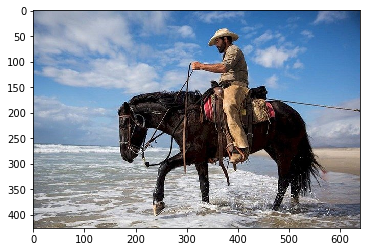

torch.Size([1, 21, 200, 5])
tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0143, 0.3994, 0.1330, 0.5558, 0.3213],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0645, 0.7145, 0.7047, 0.8592, 0.9141],
          [0.0234, 0.3522, 0.8012, 0.4709, 0.9448],
          [0.0144, 0.4127, 0.4656, 0.7114, 0.6323],
          ...,
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.00

/opt/conda/conda-bld/pytorch_1579022034529/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022034529/work/torch/csrc/autograd/python_function.cpp:648: UserWarning: Legacy autograd function object was called twice.  You will probably get incorrect gradients from this computation, as the saved tensors from the second invocation will clobber the saved tensors from the first invocation.  Please consider rewriting your autograd function in the modern style; for information on the new format, please see: https://pytorch.org/docs/stable/notes/extending.html#extending-torch-autograd


In [14]:
from utils.ssd_model import DataTransform

# 画像読み込み
image_file_path = './data/cowboy-757575_640.jpg'
img = cv2.imread(image_file_path)  # 高さ、幅、色[BGR]
height, width, channels = img.shape

# 元画像を表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 前処理にかける
color_mean = (104, 117, 123)  # B,G,Rの平均値
input_size = 300
transform = DataTransform(input_size, color_mean)
phase = 'val'
image_transformed, boxes, labels = transform(img, phase, "","")  # アノテーションないので""にする　<- 学習データならboxesとlabels必要だけど
img = torch.from_numpy(image_transformed[:,:,(2,1,0)]).permute(2, 0,1)  # BGR->RGBにして、高さ、幅、色-> 色、高さ、幅

net.eval()  # 推論モードへ
x = img.unsqueeze(0)  # 次元を増やしてミニバッチ化　　torch.Size([1, 3, 300, 300])
detections = net(x)  # torch.Size([batch_num, 21, 200(confのtop200), 5(確信度、xmin, ymin, xmax, ymax)])
print(detections.shape)
print(detections)

## 出力テンソルから確信度が一定の閾値以上のBBoxのみを取り出し元画像上に描画して表示

/opt/conda/conda-bld/pytorch_1579022034529/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022034529/work/torch/csrc/autograd/python_function.cpp:648: UserWarning: Legacy autograd function object was called twice.  You will probably get incorrect gradients from this computation, as the saved tensors from the second invocation will clobber the saved tensors from the first invocation.  Please consider rewriting your autograd function in the modern style; for information on the new format, please see: https://pytorch.org/docs/stable/notes/extending.html#extending-torch-autograd


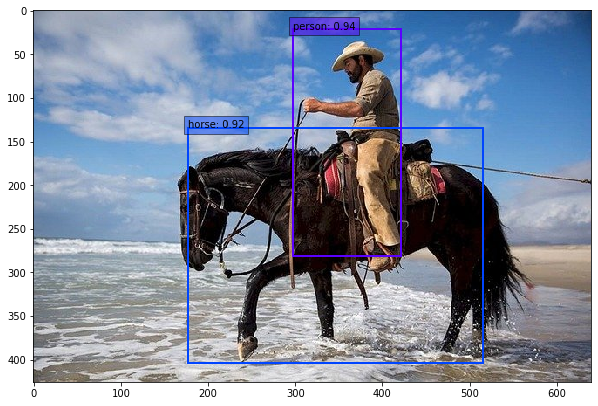

In [16]:
from utils.ssd_predict_show import SSDPredictShow

image_file_path = './data/cowboy-757575_640.jpg'

# 予測友と画像を表示
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 
               'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 
               'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

ssd = SSDPredictShow(eval_categories=voc_classes, net=net)
ssd.show(image_file_path, data_confidence_level=0.6)   # 確信度0.6以上の結果のみ表示

In [ ]:
# 他の画像でもやる